In [1]:
import pandas as pd
import plotly.express as px

from flowsight.features.rtt import backlog_timeseries

# Load Nottingham University Hospitals (RX1) backlog series
df = backlog_timeseries()        # uses helper default provider="RX1"
df.head()


,date,incomplete_pathways,within_18_weeks,beyond_18_weeks
0,2007-08-01,4186974,2395656,1791318
1,2007-09-01,3997551,2364349,1633202
2,2007-10-01,3939821,2337604,1602217
3,2007-11-01,3921962,2269968,1651994
4,2007-12-01,3861337,2180207,1680631


In [2]:
px.line(df, x="date", y="incomplete_pathways",
        title="NUH – RTT Incomplete Pathways backlog").show()

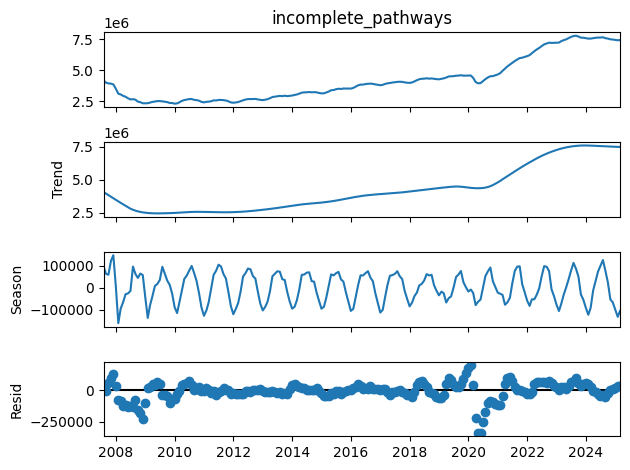

In [3]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
%matplotlib inline

series = df.set_index("date")["incomplete_pathways"]
stl = STL(series, period=12)
res = stl.fit()
res.plot()
plt.show()


In [4]:
from statsmodels.tsa.stattools import adfuller

adf_stat, p_val, *_ = adfuller(series)
print(f"ADF statistic: {adf_stat:.2f}   p-value: {p_val:.4f}")

ADF statistic: -0.25   p-value: 0.9323


In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use the same series you created earlier
series = df.set_index("date")["incomplete_pathways"]

train = series[:-6]      # last 6 months kept for a test/forecast section

# Simple seasonal model (tweak later if you wish)
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(0, 1, 1, 12),
                enforce_stationarity=False)

fit = model.fit(disp=False)
fit.summary()


c:\Users\ukwud\MLOps\NHS project\flowsight-nuh\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\ukwud\MLOps\NHS project\flowsight-nuh\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                incomplete_pathways   No. Observations:                  206
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2201.805
Date:                            Fri, 06 Jun 2025   AIC                           4411.610
Time:                                    20:41:21   BIC                           4424.359
Sample:                                08-01-2007   HQIC                          4416.780
                                     - 09-01-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5488      0.094      5.867      0.000       0.365       0.732
ma.L1          0.3289      0.114      2.873      0.004       0.105       0.553
ma.S.L12      -0.1729      0.028     -6.272      0.000      -0.227      -0.119
sigma2      4.021e+09   2.46e-12   1.63e+21      0.000    4.02e+09    4.02e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               288.22
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.68e+36. Standard errors may be unstable.
"""

In [15]:
pred = fit.get_forecast(steps=18)
forecast = (pred.predicted_mean
            .rename("forecast")
            .to_frame()
            .reset_index()
            .rename(columns={"index": "date"}))

# Ensure date column is timestamp for sort/plot
df["date"] = pd.to_datetime(df["date"])
forecast["date"] = pd.PeriodIndex(forecast["date"], freq="M").to_timestamp()

In [16]:
plot_df = (
    pd.concat(
        [df.rename(columns={"incomplete_pathways": "actual"}), forecast],
        ignore_index=True,
    )
    .sort_values("date")
)

In [18]:
fig = px.line(
    plot_df,
    x="date",                      # ← string, not plot_df["date"]
    y=["actual", "forecast"],      # ← list of column names
    labels={"value": "incomplete_pathways", "variable": "Series"},
    title="NUH RTT backlog – actual vs 18-month SARIMAX forecast",
)
fig.write_html("../outputs/rtt_backlog_forecast.html")
fig.show()


In [12]:
print(plot_df.columns.tolist())

['date', 'incomplete_pathways', 'within_18_weeks', 'beyond_18_weeks', 'forecast']
